In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations

In [44]:
## Read Dataset Sourced From Kaggle
political_data = pd.read_csv('US_Election_dataset_v1.csv')

## Remove Redundant Columns
political_data = political_data.drop(columns = ['2020 Democrat vote raw', '2020 Republican vote raw', '2020 other vote raw', '2020 Republican vote %', '2020 other vote %', 'Mean income (dollars)'])


In [45]:
## Clean data to prevent any numerical columns from being inadvertently treated as categorical ones
political_data['Some College,No Degree'] = political_data['Some College,No Degree'].astype(str).str.replace('%', '').astype(float)
political_data['Population with less than 9th grade education'] = political_data['Population with less than 9th grade education'].astype(str).str.replace('%', '').astype(float)
political_data['Population with 9th to 12th grade education, no diploma'] = political_data['Population with 9th to 12th grade education, no diploma'].astype(str).str.replace('%', '').astype(float)
political_data['High School graduate and equivalent'] = political_data['High School graduate and equivalent'].astype(str).str.replace('%', '').astype(float)
political_data['Associates Degree'] = political_data['Associates Degree'].astype(str).str.replace('%', '').astype(float)
political_data['Bachelors Degree'] = political_data['Bachelors Degree'].astype(str).str.replace('%', '').astype(float)
political_data['Graduate or professional degree'] = political_data['Graduate or professional degree'].astype(str).str.replace('%', '').astype(float)


## Fill in the missing value for median income (dollars) in Loving County, Texas
political_data['Median income (dollars)'] = (political_data['Median income (dollars)'].astype(str).str.replace(',', '').replace('-', np.nan).astype(float))
tx_median = political_data.loc[political_data['state'] == 'Georgia', 'Median income (dollars)'].median()

mask = (political_data['state'] == 'Texas') & (political_data['county'] == 'Loving County')
political_data.loc[mask, 'Median income (dollars)'] = tx_median

political_data.loc[political_data['county'] == 'Loving County', 'Median income (dollars)'].values[0]


np.float64(53350.0)

In [46]:
## Create a new column that classifies counties by party
political_data['political_party'] = ''

for index, value in political_data['2020 Democrat vote %'].items():
  if(value >= 50):
    political_data.loc[index, 'political_party'] = 'Democratic Party'
  else:
    political_data.loc[index, 'political_party'] = 'Republican Party'


political_data.head()

,Unnamed: 0,county,state,2020 Democrat vote %,Population with less than 9th grade education,"Population with 9th to 12th grade education, no diploma",High School graduate and equivalent,"Some College,No Degree",Associates Degree,Bachelors Degree,...,NH-Asian percentage,NH-Native Hawaiian and Other Pacific Islander percentage,NH-Some Other Race percentage,NH-Two or More Races percentage,"Percentage engaged in Management, business, science, and arts occupations",Percentage engaged in Service Occupations,Percentage engaged in Sales and Office,Percentage engaged in Resources and Construction,Percentage engaged in Transportation,political_party
0,"Autauga County, Alabama",Autauga County,Alabama,27.02,1.7,7.9,31.1,21.0,8.7,16.7,...,1.48,0.04,0.31,4.23,36.39,14.24,22.02,9.99,17.36,Republican Party
1,"Baldwin County, Alabama",Baldwin County,Alabama,22.41,2.0,6.4,27.8,21.7,9.6,20.0,...,0.88,0.05,0.33,4.47,35.62,17.14,24.20,9.91,13.13,Republican Party
2,"Barbour County, Alabama",Barbour County,Alabama,45.79,7.3,16.2,36.8,19.9,7.9,6.6,...,0.41,0.00,0.25,2.19,27.73,20.16,19.49,12.53,20.09,Republican Party
3,"Bibb County, Alabama",Bibb County,Alabama,20.70,6.4,14.7,40.9,19.1,8.0,6.6,...,0.12,0.04,0.21,2.69,22.22,15.32,20.57,16.43,25.47,Republican Party
4,"Blount County, Alabama",Blount County,Alabama,9.57,7.1,11.1,35.3,20.7,11.0,9.4,...,0.29,0.02,0.17,3.89,26.75,12.98,22.73,15.81,21.73,Republican Party


In [47]:
## Preprocessing Stage for all models: Logistic Regression, Random Forest, and Decision Tree Classification
political_data = political_data.drop(columns = '2020 Democrat vote %')

X = political_data.drop(columns = ['political_party', 'county', 'Unnamed: 0'])
y = political_data['political_party']

num_features = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include = ['category', 'object']).columns.tolist()

num_transformer = Pipeline([
  ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
   ('scaler', OneHotEncoder(handle_unknown = 'ignore'))
])
preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features)
)

## Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [48]:
## Determine whether the target set is balanced
print("\nTarget Set Breakdown (Percentage):")
print(political_data['political_party'].value_counts(normalize=True) * 100)


Target Set Breakdown (Percentage):
political_party
Republican Party    83.455297
Democratic Party    16.544703
Name: proportion, dtype: float64


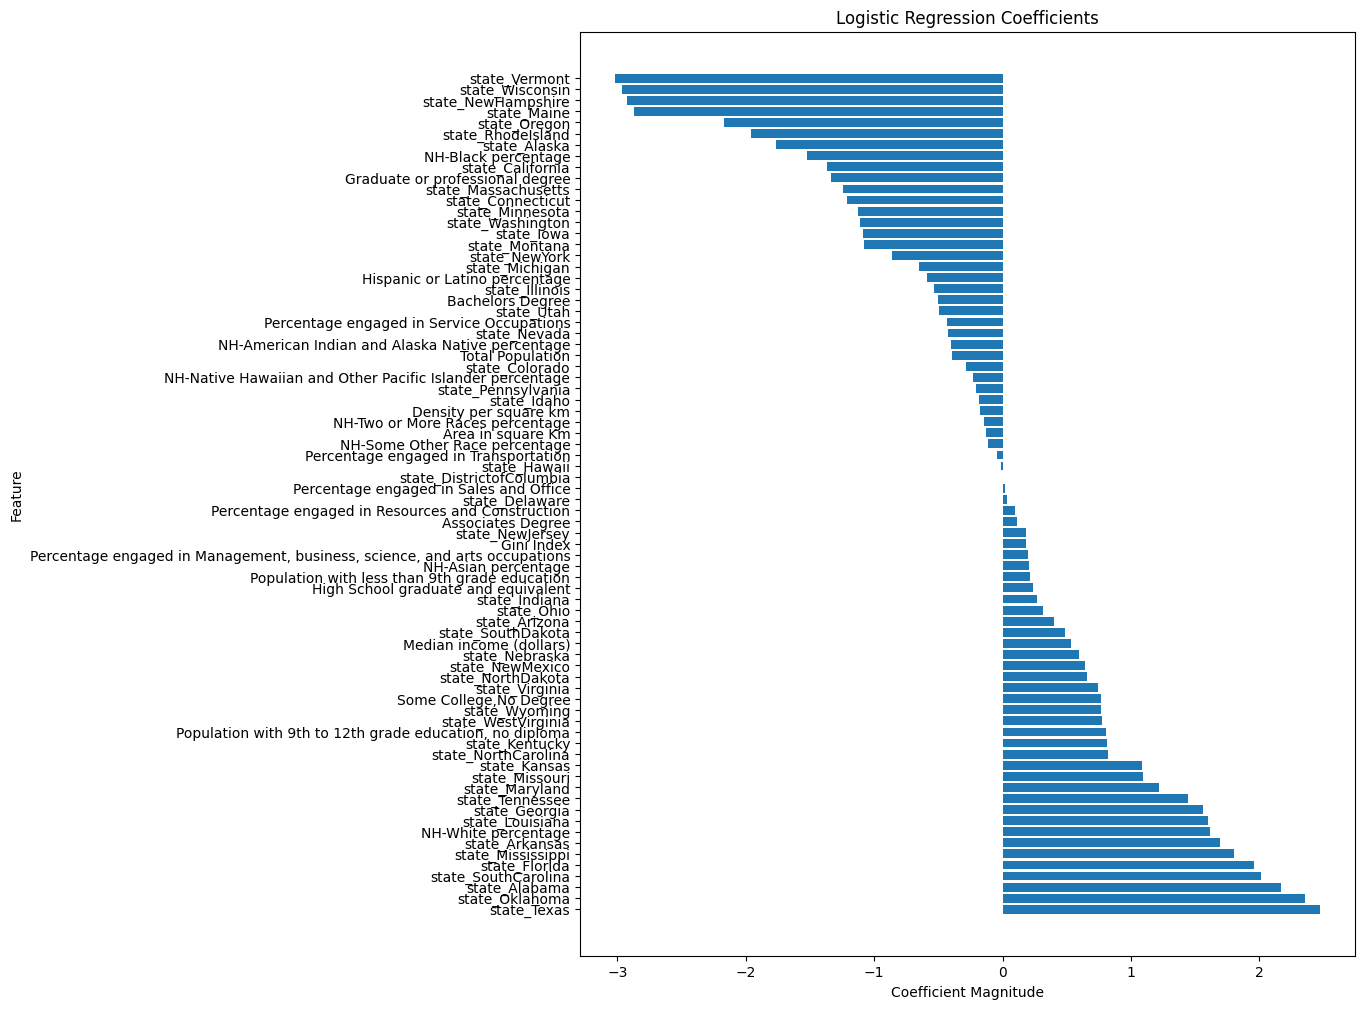

In [49]:
## Create the Logistic Regression Model
lgr_pipe = Pipeline([('transforms', preprocessor), ('model', LogisticRegression(class_weight='balanced'))])
lgr_pipe.fit(X_train, y_train)

y_test_pred_lgr = lgr_pipe.predict(X_test)
y_train_pred_lgr = lgr_pipe.predict(X_train)


## Determine the direction and magnitude of model coefficients
coef_df = pd.DataFrame({
    'feature': lgr_pipe.named_steps['transforms'].get_feature_names_out(),
    'coef': lgr_pipe[-1].coef_[0]
})

coef_df['feature'] = coef_df['feature'].str.replace(r'^pipeline-\d+__', '', regex=True)
coef_df.sort_values(by = 'coef', ascending = False, inplace = True)
plt.figure(figsize = (10, 12))
plt.barh(coef_df['feature'], coef_df['coef'])
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()


Logistic Regression Test Accuracy:  88.87122416534181 %
Democratic Party Precision:  61.48648648648649 %
Democratic Party Recall:  87.5 %


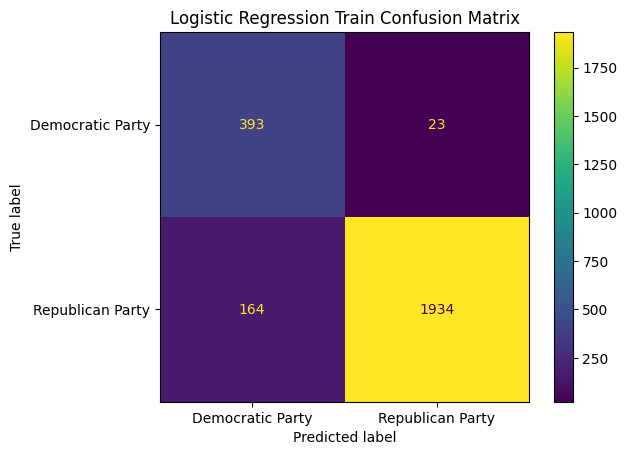

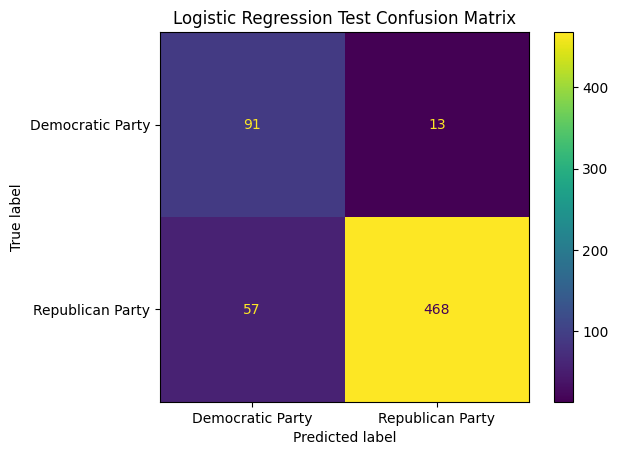

In [50]:
## Compute the accuracy, precision, and recall of the Logistic Regression Model
lgr_accuracy = accuracy_score(y_test, y_test_pred_lgr)
print('Logistic Regression Test Accuracy: ', lgr_accuracy*100, "%")

lgr_precision = precision_score(y_test, y_test_pred_lgr, pos_label='Democratic Party')
lgr_recall = recall_score(y_test, y_test_pred_lgr, pos_label='Democratic Party')

print("Democratic Party Precision: ", lgr_precision*100, '%')
print("Democratic Party Recall: ", lgr_recall*100, '%')


## Display the Train and Test Confusion Matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred_lgr)
ConfusionMatrixDisplay(confusion_matrix_train, display_labels=lgr_pipe.classes_).plot()
plt.title('Logistic Regression Train Confusion Matrix')
plt.show()


confusion_matrix_test = confusion_matrix(y_test, y_test_pred_lgr)
ConfusionMatrixDisplay(confusion_matrix_test, display_labels=lgr_pipe.classes_).plot()
plt.title('Logistic Regression Test Confusion Matrix')
plt.show()


In [51]:
## Use GridSearchCV to optimize the Logistic Regression Model's Parameters
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs'],
    'model__class_weight': [None, 'balanced']
}
grid_search = GridSearchCV(lgr_pipe, param_grid, cv=5)

grid_search.fit(X_train, y_train)


print("Best Parameters: ", grid_search.best_params_)
print("Best CV Score: ", grid_search.best_score_)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Parameters:  {'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV Score:  0.9419300927502713


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
## Logistic Regression County Prediction Model

case_study_county_data = {
   'state': 'Pennsylvania',
    'Population with less than 9th grade education': 1.8,
    'Population with 9th to 12th grade education, no diploma': 3.5,
    'High School graduate and equivalent': 27.8,
    'Some College,No Degree': 15.4,
    'Associates Degree': 8.2,
    'Bachelors Degree': 25.7,
    'Graduate or professional degree': 17.6,
    'Gini Index': 0.4446,
    'Median income (dollars)': 107826,
    'Area in square Km': 1565.3,
    'Density per square km': 412.17,
    'Total Population': 646538,
    'Hispanic or Latino percentage': 6.15,
    'NH-White percentage': 80.67,
    'NH-Black percentage': 3.91,
    'NH-Asian percentage': 5.42,
    'NH-American Indian and Alaska Native percentage': 0.08,
    'NH-Some Other Race percentage': 0.39,
    'NH-Native Hawaiian and Other Pacific Islander percentage': 0.02,
    'NH-Two or More Races percentage': 3.35,
    'Percentage engaged in Management, business, science, and arts occupations': 48.16,
    'Percentage engaged in Service Occupations': 12.64,
    'Percentage engaged in Sales and Office': 20.97,
    'Percentage engaged in Resources and Construction': 7.55,
    'Percentage engaged in Transportation': 10.68,
}

case_study_df = pd.DataFrame([case_study_county_data])

predicted_party = lgr_pipe.predict(case_study_df)

predicted_proba = lgr_pipe.predict_proba(case_study_df)

print(f"Predicted Party: {predicted_party[0]}")
print(f"Democratic Party Probability: {predicted_proba[0][0]:.2f}, Republican Party Probability: {predicted_proba[0][1]:.2f}")



Predicted Party: Democratic Party
Democratic Party Probability: 0.70, Republican Party Probability: 0.30


Random Forest Test Accuracy:  92.68680445151033 %
Democratic Party Precision:  84.52380952380952 %
Democratic Party Recall:  68.26923076923077 %


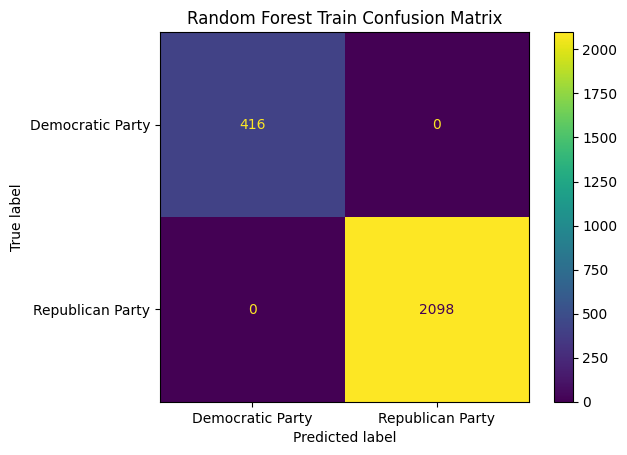

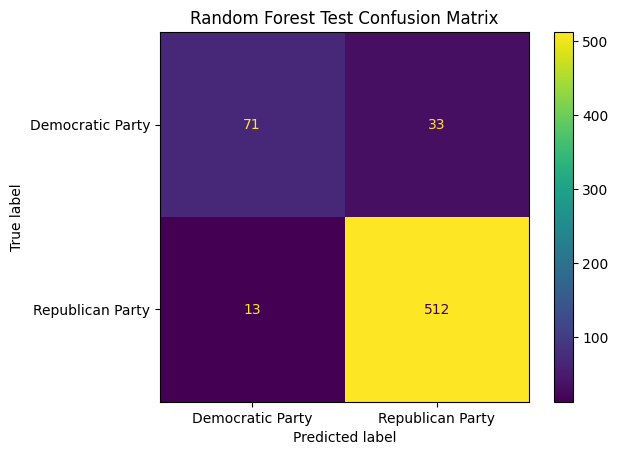

In [53]:
## Create the Random Forest Model

rf_pipe = Pipeline([
    ('transforms', preprocessor),
    ('model', RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced'))
])


rf_pipe.fit(X_train, y_train)


y_train_pred_rf = rf_pipe.predict(X_train)
y_test_pred_rf = rf_pipe.predict(X_test)

## Compute the accuracy, precision, and recall of the Random Forest Model
rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
print('Random Forest Test Accuracy: ', rf_accuracy*100, "%")


rf_precision = precision_score(y_test, y_test_pred_rf, pos_label='Democratic Party')
rf_recall = recall_score(y_test, y_test_pred_rf, pos_label='Democratic Party')

print("Democratic Party Precision: ", rf_precision*100, '%')
print("Democratic Party Recall: ", rf_recall*100, '%')

## Display the Train and Test Confusion Matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred_rf)
ConfusionMatrixDisplay(confusion_matrix_train, display_labels=rf_pipe.classes_).plot()
plt.title('Random Forest Train Confusion Matrix')
plt.show()


confusion_matrix_test = confusion_matrix(y_test, y_test_pred_rf)
ConfusionMatrixDisplay(confusion_matrix_test, display_labels=rf_pipe.classes_).plot()
plt.title('Random Forest Test Confusion Matrix')
plt.show()



Text(0.5, 1.0, 'Random Forest Feature Significance')

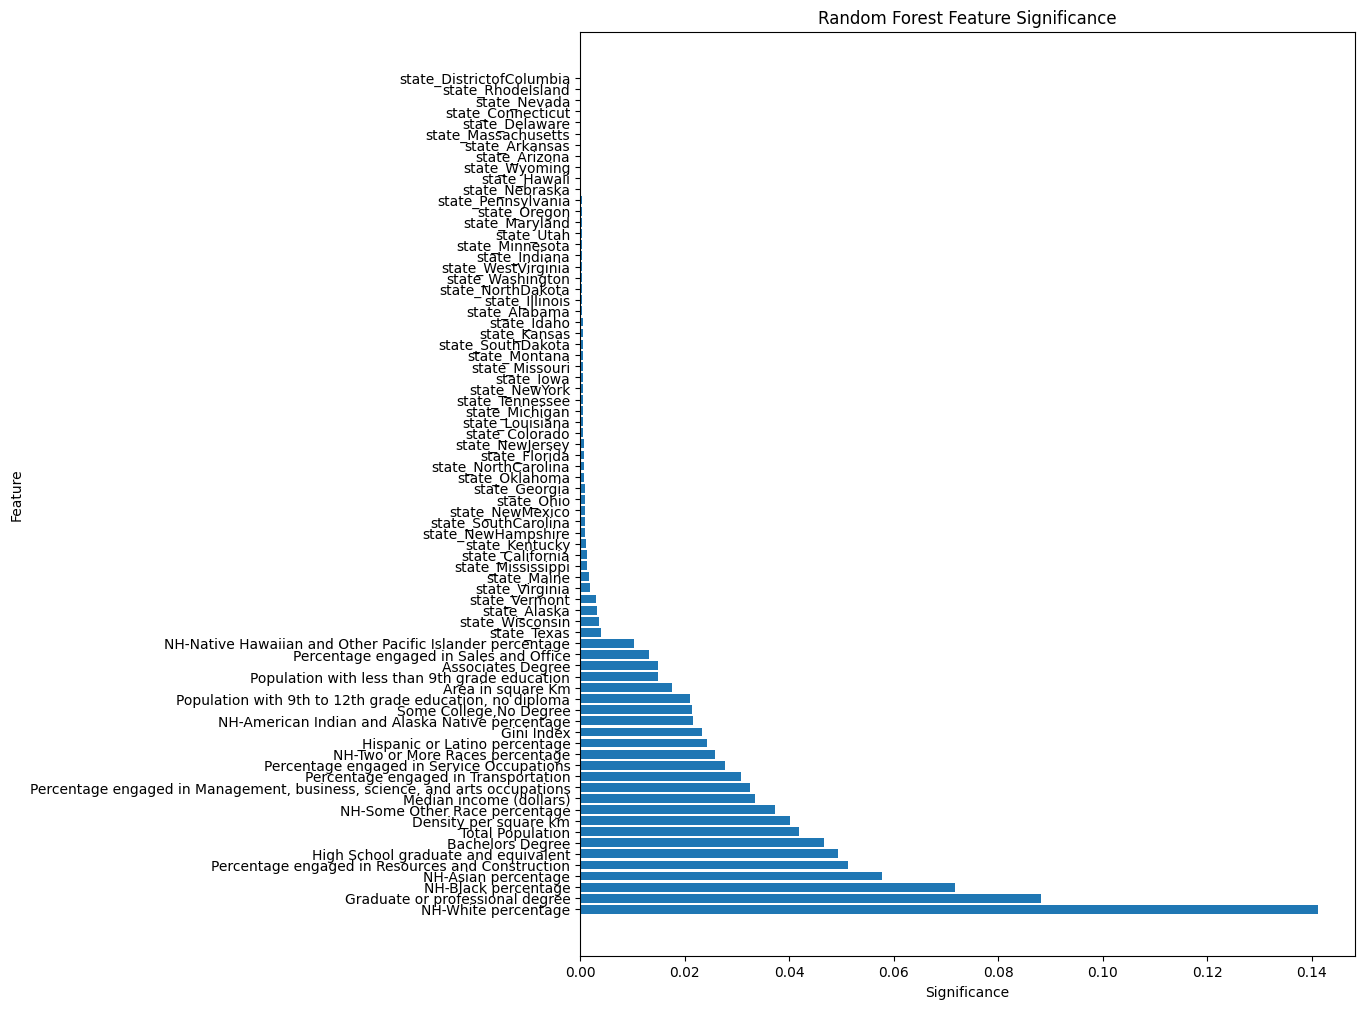

In [54]:
## Determine the Significance of Individual Features based on the Random Forest Model
feature_significance = rf_pipe[-1].feature_importances_
feature_names = rf_pipe.named_steps['transforms'].get_feature_names_out()

rf_significance = pd.DataFrame(
    {'feature': feature_names, 'significance': feature_significance}
)

rf_significance.sort_values(by = 'significance', ascending = False, inplace = True)
rf_significance['feature'] = rf_significance['feature'].str.replace(r'^pipeline-\d+__', '', regex=True)

plt.figure(figsize = (10, 12))
plt.barh(rf_significance['feature'], rf_significance['significance'])
plt.xlabel('Significance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Significance')

In [55]:
## Random Forest County Prediction Model

new_county_data = {
    'state': 'Pennsylvania',
    'Population with less than 9th grade education': 1.8,
    'Population with 9th to 12th grade education, no diploma': 3.5,
    'High School graduate and equivalent': 27.8,
    'Some College,No Degree': 15.4,
    'Associates Degree': 8.2,
    'Bachelors Degree': 25.7,
    'Graduate or professional degree': 17.6,
    'Gini Index': 0.4446,
    'Median income (dollars)': 107826,
    'Area in square Km': 1565.3,
    'Density per square km': 412.17,
    'Total Population': 646538,
    'Hispanic or Latino percentage': 6.15,
    'NH-White percentage': 80.67,
    'NH-Black percentage': 3.91,
    'NH-Asian percentage': 5.42,
    'NH-American Indian and Alaska Native percentage': 0.08,
    'NH-Some Other Race percentage': 0.39,
    'NH-Native Hawaiian and Other Pacific Islander percentage': 0.02,
    'NH-Two or More Races percentage': 3.35,
    'Percentage engaged in Management, business, science, and arts occupations': 48.16,
    'Percentage engaged in Service Occupations': 12.64,
    'Percentage engaged in Sales and Office': 20.97,
    'Percentage engaged in Resources and Construction': 7.55,
    'Percentage engaged in Transportation': 10.68,
}
new_county_df = pd.DataFrame([new_county_data])

predicted_party = rf_pipe.predict(new_county_df)

predicted_proba = rf_pipe.predict_proba(new_county_df)

print(f"Predicted Party: {predicted_party[0]}")
print(f"Democratic Party Probability: {predicted_proba[0][0]:.2f}, Republican Party Probability: {predicted_proba[0][1]:.2f}")



Predicted Party: Democratic Party
Democratic Party Probability: 0.84, Republican Party Probability: 0.16


Decision Tree Test Accuracy:  88.23529411764706 %
Democratic Party Precision:  62.5 %
Democratic Party Recall:  72.11538461538461 %


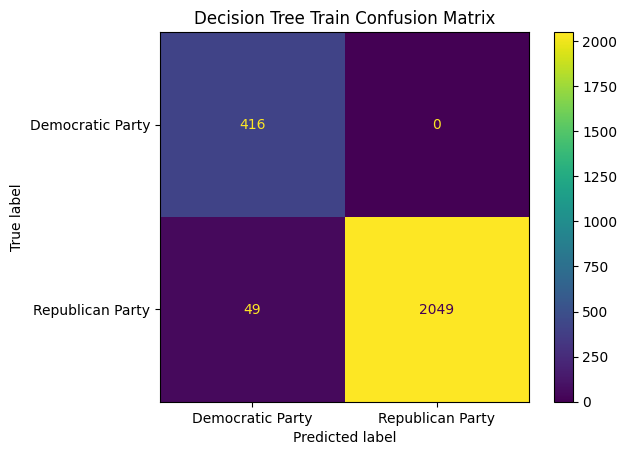

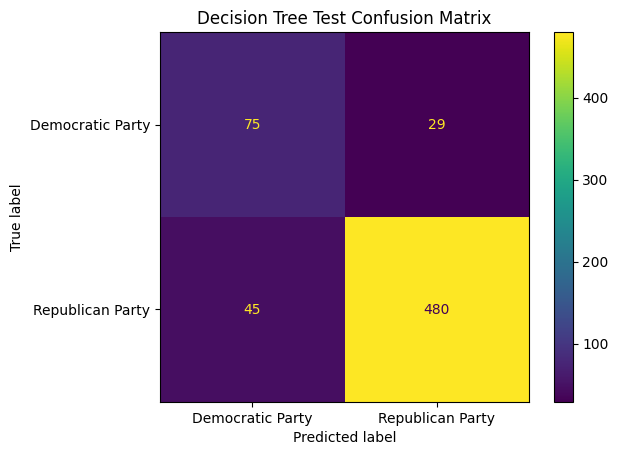

In [56]:
## Create the Decision Tree Classification Model
dt_pipe = Pipeline([
    ('transforms', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth = 12))
])

dt_pipe.fit(X_train, y_train)

y_test_pred_dt = dt_pipe.predict(X_test)
y_train_pred_dt = dt_pipe.predict(X_train)

# Compute the accuracy, precision, and recall of the Decision Tree Model
dt_accuracy = accuracy_score(y_test, y_test_pred_dt)
print('Decision Tree Test Accuracy: ', dt_accuracy*100, "%")


dt_precision = precision_score(y_test, y_test_pred_dt, pos_label='Democratic Party')
dt_recall = recall_score(y_test, y_test_pred_dt, pos_label='Democratic Party')
print("Democratic Party Precision: ", dt_precision*100, '%')
print("Democratic Party Recall: ", dt_recall*100, '%')


## Display the Train and Test Confusion Matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred_dt)
ConfusionMatrixDisplay(confusion_matrix_train, display_labels=dt_pipe.classes_).plot()
plt.title('Decision Tree Train Confusion Matrix')
plt.show()


confusion_matrix_test = confusion_matrix(y_test, y_test_pred_dt)
ConfusionMatrixDisplay(confusion_matrix_test, display_labels=dt_pipe.classes_).plot()
plt.title('Decision Tree Test Confusion Matrix')
plt.show()




Text(0.5, 1.0, 'Decision Tree Feature Significance')

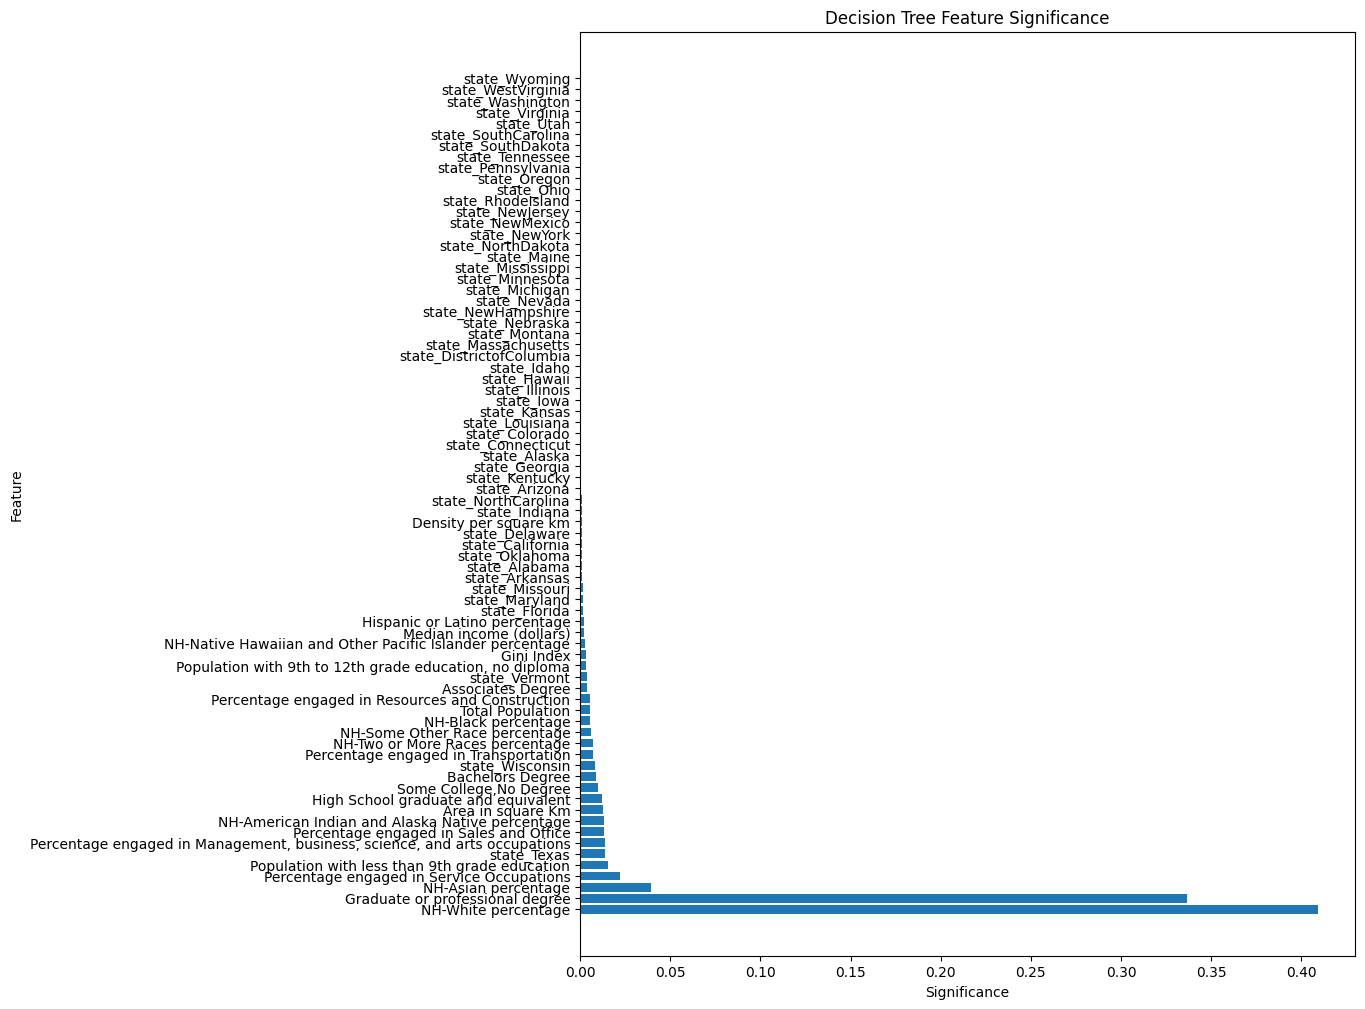

In [57]:
## Determine the Significance of Features as per the Decision Tree Model
dt_feature_significance = dt_pipe[-1].feature_importances_
dt_feature_names = dt_pipe.named_steps['transforms'].get_feature_names_out()

dt_significance = pd.DataFrame(
    {'feature': dt_feature_names, 'significance': dt_feature_significance}
)

dt_significance.sort_values(by = 'significance', ascending = False, inplace = True)
dt_significance['feature'] = dt_significance['feature'].str.replace(r'^pipeline-\d+__', '', regex=True)

plt.figure(figsize = (10, 12))
plt.barh(dt_significance['feature'], dt_significance['significance'])
plt.xlabel('Significance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Significance')


In [58]:
## Decision Tree County Prediction Model

new_county_data = {
   'state': 'Pennsylvania',
    'Population with less than 9th grade education': 1.8,
    'Population with 9th to 12th grade education, no diploma': 3.5,
    'High School graduate and equivalent': 27.8,
    'Some College,No Degree': 15.4,
    'Associates Degree': 8.2,
    'Bachelors Degree': 25.7,
    'Graduate or professional degree': 17.6,
    'Gini Index': 0.4446,
    'Median income (dollars)': 107826,
    'Area in square Km': 1565.3,
    'Density per square km': 412.17,
    'Total Population': 646538,
    'Hispanic or Latino percentage': 6.15,
    'NH-White percentage': 80.67,
    'NH-Black percentage': 3.91,
    'NH-Asian percentage': 5.42,
    'NH-American Indian and Alaska Native percentage': 0.08,
    'NH-Some Other Race percentage': 0.39,
    'NH-Native Hawaiian and Other Pacific Islander percentage': 0.02,
    'NH-Two or More Races percentage': 3.35,
    'Percentage engaged in Management, business, science, and arts occupations': 48.16,
    'Percentage engaged in Service Occupations': 12.64,
    'Percentage engaged in Sales and Office': 20.97,
    'Percentage engaged in Resources and Construction': 7.55,
    'Percentage engaged in Transportation': 10.68,
}
new_county_df = pd.DataFrame([new_county_data])

predicted_party = dt_pipe.predict(new_county_df)

predicted_proba = dt_pipe.predict_proba(new_county_df)

print(f"Predicted Party: {predicted_party[0]}")
print(f"Democratic Party Probability: {predicted_proba[0][0]:.2f}, Republican Party Probability: {predicted_proba[0][1]:.2f}")



Predicted Party: Democratic Party
Democratic Party Probability: 0.94, Republican Party Probability: 0.06
